In [7]:
import math
import numpy as np
import scipy.special as sp
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from numba import jit,int64,float64
import time
import scipy.optimize as sciopt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

In [8]:
#Parameters - self-activation a, cross-repression r, decay k, noise alpha:
a = np.array([0,0])
r = np.array([1,1])
k = np.array([1,1])
alpha = np.array([0.1,0.1])
#Hill coefficients:
n = np.array([[4,4],[4,4]])
theta = np.array([[0.5,0.5],[0.5,0.5]])

#The total time and dt::
T = 40
dt = 0.005
#Other time-related variables related to these two:
Nt = round(T/dt)
sqrt_dt = np.sqrt(dt)
TimeRange = np.linspace(0,T,num=Nt)
# #This is to calculate the dynamic threshold moving average:
# timeBase = 2*int(Nt/100)
# #Time to plot utility against:
# time_trunc = TimeRange[int((timeBase/2)-1):-int(timeBase/2)]

#Let's call num_traj the number of trajectories:
num_traj = 10000

#The threshold above which we say x_i is high:
thresh = np.array([0.8,0.8])
#The stability threshold; a trajectory has to stay above this:
stability_thresh = 0.9

#A minimum tolerance:
eps = 1e-6

In [9]:
#Self-activation:
@jit(nopython=True)
def activation(x,a,n,theta):
    if (x>=0):
        return (a*x**n)/(x**n + theta**n)
    else:
        return 0

#Cross-inhibition
@jit(nopython=True)
def repression(x,r,n,theta):
    if (x>0):
        return (r*theta**n)/(x**n + theta**n)
    else:
        return 0

# #Bias (for external signals):
# @jit(nopython=True)
# def ext_bias(x1,x2,scale1,scale2,t):
# #     return (x1-x2,x2-x1)
#     temp = 0
#     return (temp,0)

#Constant external bias:
@jit(nopython=True)
def ext_bias_const(field):
    return (field,0)
    
# #This solves the system fwd using simple Euler-Maruyama:
# @jit(nopython=True)
# def Solver(initial,a,r,k,n,theta,alpha):
#     final = np.empty((2,num_traj,Nt))
#     final[:,:,0] = initial
#     #Solving the system forward in time:
#     for i in range(num_traj):
#         for t in range(1,Nt):
#             #Equation for first species:
#             temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
#             noise = rand.normalvariate(0,alpha[0]*temp)
#             final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
#                                                + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
#                                                - k[0]*final[0,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[0]) \
#                                                 + sqrt_dt*noise
#             #Equation for second:
#             temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
#             noise = rand.normalvariate(0,alpha[1]*temp)
#             final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
#                                                + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
#                                                - k[1]*final[1,i,t-1] + ext_bias(final[0,i,t-1],final[1,i,t-1],t)[1]) \
#                                                 + sqrt_dt*noise
#     return final

#A solver with some constant extrinsic bias:
@jit(nopython=True)
def Solver_const_ext_bias(initial,a,r,k,n,theta,alpha,ext_bias_field):
    final = np.empty((2,num_traj,Nt))
    final[:,:,0] = initial
    #Solving the system forward in time:
    for i in range(num_traj):
        for t in range(1,Nt):
            #Equation for first species:
            temp = np.sqrt(np.maximum(final[0,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[0]*temp)
            final[0,i,t] = final[0,i,t-1] + dt*(activation(final[0,i,t-1],a[0],n[0,0],theta[0,0]) \
                                               + repression(final[1,i,t-1],r[0],n[1,0],theta[1,0]) \
                                               - k[0]*final[0,i,t-1] + ext_bias_const(ext_bias_field)[0]) \
                                                + sqrt_dt*noise
            #Equation for second:
            temp = np.sqrt(np.maximum(final[1,i,t-1],0.01))
            noise = rand.normalvariate(0,alpha[1]*temp)
            final[1,i,t] = final[1,i,t-1] + dt*(activation(final[1,i,t-1],a[1],n[1,1],theta[1,1]) \
                                               + repression(final[0,i,t-1],r[1],n[0,1],theta[0,1]) \
                                               - k[1]*final[1,i,t-1] + ext_bias_const(ext_bias_field)[1]) \
                                                + sqrt_dt*noise
    return final


#Classifier:
# @jit(nopython=True)
def fate_classifier(traj):
    #Stability factor of trajectories:
    cross_flags = np.zeros((2,num_traj))
    cross_times = np.ones((2,num_traj))*Nt
    for axis_idx in range(2):
        #Axis crossings:
        for traj_idx in range(num_traj):
            if (np.size(np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0]) != 0):
                cross_flags[axis_idx,traj_idx] = 1
                cross_times[axis_idx,traj_idx] = np.where(traj[axis_idx,traj_idx]>thresh[axis_idx])[0][0]
                    
    #Stability factor: after the threshold is crossed, how much time the traj spends above it:
    stability_factrs = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
#             if (cross_flags[axis_idx,traj_idx]==0):
#                 stability_factrs[axis_idx,traj_idx] = -1
            if (cross_flags[axis_idx,traj_idx]==1):
                stability_factrs[axis_idx,traj_idx] = np.sum(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):]>thresh[axis_idx])\
                /len(traj[axis_idx,traj_idx,int(cross_times[axis_idx,traj_idx]):])
    
    #Stability threshold - trajectories that spend more than this above the concentration threshold are considered committed:
#     stability_thresh = 0.8
    #Classifying fates:
    fates = np.zeros((2,num_traj))
    for axis_idx in range(2):
        for traj_idx in range(num_traj):
            if (cross_times[axis_idx,traj_idx]<=int(Nt/2) and stability_factrs[axis_idx,traj_idx]>=stability_thresh):
                fates[axis_idx,traj_idx]=1
                
    return stability_factrs,fates

def fate_fractions(fates):
    #Initializing:
    fate_frax = np.zeros(4)
    fate_frax[0] = np.sum((fates[0]==0) & (fates[1]==0))/num_traj
    fate_frax[1] = np.sum((fates[0]==1) & (fates[1]==0))/num_traj
    fate_frax[2] = np.sum((fates[0]==0) & (fates[1]==1))/num_traj
    fate_frax[3] = np.sum((fates[0]==1) & (fates[1]==1))/num_traj
    
    return fate_frax

def traj_moments(traj,fates):
    #Finding the fate fractions first:
    fate_frax = fate_fractions(fates)
    
    #Flags, if fate_frac is zero for a fate then no avg or std is calculated:
    fate_flags = np.array([False for i in range(4)])
    
    #Flag = True if that fate exists in the population:
    for fate_idx in range(4):
        if (fate_frax[fate_idx] != 0):
            fate_flags[fate_idx] = True
            
    #Average trajectories and standard deviation around them:
    avg_traj = np.zeros((4,2,Nt))
    std_traj = np.zeros((4,2,Nt))
    
    if (fate_flags[0]==True):
        avg_traj[0,:,:] = np.mean(traj[:,(fates[0]==0) & (fates[1]==0),:],axis=1)
        std_traj[0,:,:] = np.std(traj[:,(fates[0]==0) & (fates[1]==0),:],axis=1)

    if (fate_flags[1]==True):
        avg_traj[1,:,:] = np.mean(traj[:,(fates[0]==1) & (fates[1]==0),:],axis=1)
        std_traj[1,:,:] = np.std(traj[:,(fates[0]==1) & (fates[1]==0),:],axis=1)

    if (fate_flags[2]==True):
        avg_traj[2,:,:] = np.mean(traj[:,(fates[0]==0) & (fates[1]==1),:],axis=1)
        std_traj[2,:,:] = np.std(traj[:,(fates[0]==0) & (fates[1]==1),:],axis=1)

    if (fate_flags[3]==True):
        avg_traj[3,:,:] = np.mean(traj[:,(fates[0]==1) & (fates[1]==1),:],axis=1)
        std_traj[3,:,:] = np.std(traj[:,(fates[0]==1) & (fates[1]==1),:],axis=1)
        
    return (avg_traj,std_traj)

0.0


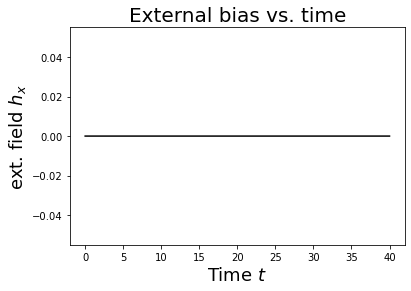

In [10]:
#The initial conditions:
x0 = np.zeros((2,num_traj))
#Starting at the saddle point (0.5,0.5):
# x0 = 0.5*np.ones((2,num_traj))
# #Uniform around mean:
# init_bias = 0
# x0[0,:] = init_bias*np.ones(num_traj)

#For a total (constant) bump of 0.1, we need to apply 0.1/T at each timestep:
ext_bias_field = 0/T
ext_bias_dyn = ext_bias_field*np.ones_like(TimeRange)

plt.plot(TimeRange,ext_bias_dyn,color='k')
plt.xlabel(r"Time $t$",fontsize=18)
plt.ylabel(r"ext. field $h_x$",fontsize=18)
plt.title("External bias vs. time",fontsize=20)

print(np.trapz(ext_bias_dyn,x=TimeRange))

In [11]:
#Generating some trajectories:
start_time = time.time()
traj_simple = np.empty((2,num_traj,Nt))
traj_simple = Solver_const_ext_bias(x0,a,r,k,n,theta,alpha,ext_bias_field)
end_time = time.time()
loop_time = end_time - start_time
print(f"Time taken: {loop_time} s.")

Time taken: 14.094251871109009 s.


In [12]:
#Now testing the fates and stability factors:
stability_factrs,fates = fate_classifier(traj_simple)
fate_frax = fate_fractions(fates)
avg_traj,std_traj = traj_moments(traj_simple,fates)
#Fate fractions:
print(stability_factrs)
print(np.shape(avg_traj))
print(fate_frax)

[[0.99985846 0.         0.         ... 0.99082691 0.         0.        ]
 [0.         0.99804305 0.99466046 ... 0.         0.99822671 0.99904567]]
(4, 2, 8000)
[0.     0.4999 0.5001 0.    ]


In [ ]:
#Defining our grid points and making the grid:
x = np.arange(0, 2*(a[0]+r[0]), 0.1)
y = np.arange(0, 2*(a[1]+r[1]), 0.1)
X, Y = np.meshgrid(x, y)

#The velocity field:
x_dot = (a[0]*X**n[0,0])/(X**n[0,0] + theta[0,0]**n[0,0]) + (r[0]*theta[1,0]**n[1,0])/(Y**n[1,0] + theta[1,0]**n[1,0]) - k[0]*X + ext_bias_field
y_dot = (a[1]*Y**n[1,1])/(Y**n[1,1] + theta[1,1]**n[1,1]) + (r[1]*theta[0,1]**n[0,1])/(X**n[0,1] + theta[0,1]**n[0,1]) - k[1]*Y

# #Only the additional x-bias:
# x_dot = 0.01
# y_dot = 0
 
# creating plot
fig, ax = plt.subplots(figsize =(6.4, 6.4))
ax.quiver(X, Y, x_dot, y_dot)
#Diagonal:
ax.plot([0, 1],[0, 1],transform=ax.transAxes,color='k',ls=':')
#Thresholds:
ax.axvline(thresh[0],color='k',ls=':')
ax.axhline(thresh[1],color='k',ls=':')

#Total state space visited, all:
ax.scatter(traj_simple[0,(fates[0]==0)&(fates[1]==0),:],traj_simple[1,(fates[0]==0)&(fates[1]==0),:],color=CB_colors[0],marker="o",alpha=0.01)
ax.scatter(traj_simple[0,(fates[0]==1)&(fates[1]==0),:],traj_simple[1,(fates[0]==1)&(fates[1]==0),:],color=CB_colors[1],marker="o",alpha=0.01)
ax.scatter(traj_simple[0,(fates[0]==0)&(fates[1]==1),:],traj_simple[1,(fates[0]==0)&(fates[1]==1),:],color=CB_colors[2],marker="o",alpha=0.01)
ax.scatter(traj_simple[0,(fates[0]==1)&(fates[1]==1),:],traj_simple[1,(fates[0]==1)&(fates[1]==1),:],color=CB_colors[3],marker="o",alpha=0.01)

# # Final points:
# ax.scatter(traj_simple[0,(fates[0]==0)&(fates[1]==0),-1],traj_simple[1,(fates[0]==0)&(fates[1]==0),-1],color=CB_colors[0],marker="o",alpha=1)
# ax.scatter(traj_simple[0,(fates[0]==1)&(fates[1]==0),-1],traj_simple[1,(fates[0]==1)&(fates[1]==0),-1],color=CB_colors[1],marker="o",alpha=1)
# ax.scatter(traj_simple[0,(fates[0]==0)&(fates[1]==1),-1],traj_simple[1,(fates[0]==0)&(fates[1]==1),-1],color=CB_colors[2],marker="o",alpha=1)
# ax.scatter(traj_simple[0,(fates[0]==1)&(fates[1]==1),-1],traj_simple[1,(fates[0]==1)&(fates[1]==1),-1],color=CB_colors[3],marker="o",alpha=1) 

ax.set_aspect('equal')
ax.set_xlabel(r"Marker (coordinate) $x$",fontsize=18)
ax.set_ylabel(r"Marker (coordinate) $y$",fontsize=18)
ax.set_title("Flow-field and explored region",fontsize=20)

In [ ]:
#Let's see how the trajectories look:
fig,ax = plt.subplots(1,2,figsize=[9.6,4.8],sharey=True)

ax[0].plot(TimeRange,avg_traj[1,0],c=CB_colors[1],label="x")
ax[0].fill_between(TimeRange,avg_traj[1,0]-std_traj[1,0],avg_traj[1,0]+std_traj[1,0],color=CB_colors[1],alpha=0.5)
ax[0].plot(TimeRange,avg_traj[1,1],c=CB_colors[2],label="y")
ax[0].fill_between(TimeRange,avg_traj[1,1]-std_traj[1,1],avg_traj[1,1]+std_traj[1,1],color=CB_colors[2],alpha=0.5)
ax[0].axhline(thresh[0],color='k',ls='--')
ax[0].set_xlabel(r"Time $t$",fontsize=18)
ax[0].set_ylabel(r"$x$ and $y$",fontsize=18)
ax[0].legend(loc="best",fontsize=12)
ax[0].set_title("Cells that choose fate 1",fontsize=20)

ax[1].plot(TimeRange,avg_traj[2,0],c=CB_colors[1],label="x")
ax[1].fill_between(TimeRange,avg_traj[2,0]-std_traj[2,0],avg_traj[2,0]+std_traj[2,0],color=CB_colors[1],alpha=0.5)
ax[1].plot(TimeRange,avg_traj[2,1],c=CB_colors[2],label="y")
ax[1].fill_between(TimeRange,avg_traj[2,1]-std_traj[2,1],avg_traj[2,1]+std_traj[2,1],color=CB_colors[2],alpha=0.5)
ax[1].axhline(thresh[0],color='k',ls='--')
ax[1].set_xlabel(r"Time $t$",fontsize=18)
ax[1].legend(loc="best",fontsize=12)
ax[1].set_title("Cells that choose fate 2",fontsize=20)

fig.suptitle(fr"Average trajectories",fontsize=22,y=1.02)

In [ ]:
#Now let's vary the constant external bias, keeping theta and noise fixed:
ext_bias_arr = np.array([i/100 for i in range(11)])/T
fate_frax_bias = np.zeros((len(ext_bias_arr),4))

for ext_bias_idx in range(len(ext_bias_arr)):
#     print(f"field: {ext_bias_arr[ext_bias_idx]}")
#     print(f"time integral of field: {np.trapz(ext_bias_arr[ext_bias_idx]*np.ones_like(TimeRange),x=TimeRange)}\n")
    
    #Generating the constant external field:
    field = ext_bias_arr[ext_bias_idx]
    
    #Initial conditions, exactly at (0,0):
    x0 = np.zeros((2,num_traj))
    
    #Time evolution given the constant external field:
    traj_ext_bias = np.empty((2,num_traj,Nt))
    traj_ext_bias = Solver_const_ext_bias(x0,a,r,k,n,theta,alpha,field)
    
    #Calculating stabilities and fate fractions:
    stability_factrs,fates = fate_classifier(traj_ext_bias)
    fate_frax_bias[ext_bias_idx] = fate_fractions(fates)
#     avg_traj,std_traj = traj_moments(traj_ext_bias,fates)    

In [ ]:
plt.scatter(ext_bias_arr,fate_frax_bias[:,1])

In [ ]:
fate_frax_bias

In [6]:
X

NameError: name 'X' is not defined